In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import colorsys

In [2]:
def leakyrelu(x):
    return tf.nn.leaky_relu(x, alpha=0.1, name="leaky_relu")

# size=[filter_width, output_channel]
def conv(x,size=[None,None],name=None,pad='SAME',batch=True,pooling=False,activation='leakyrelu',
        bias=False,split=False):
    m,w,h,c = x.shape
    filt_width = size[0]
    out_channel = size[1]
    W = tf.Variable(np.zeros([filt_width,filt_width,c,out_channel]),dtype=tf.float32,name=name+'/kernel')
    layer = tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
    if bias:
        b = tf.Variable(np.zeros(out_channel),dtype=tf.float32,name=name+'/bias')
        layer = tf.nn.bias_add(layer,b)
    if batch:
        mean = tf.Variable(np.zeros((out_channel,)), dtype=tf.float32, name=name+'_bn/moving_mean')
        variance = tf.Variable(np.zeros((out_channel,)), dtype=tf.float32, name=name+'_bn/moving_variance')
        beta = tf.Variable(np.zeros((out_channel,)), dtype=tf.float32, name=name+'_bn/beta')
        gamma = tf.Variable(np.zeros((out_channel,)), dtype=tf.float32, name=name+'_bn/gamma')
        layer = tf.nn.batch_normalization(layer, mean=mean, variance=variance,
                                          offset=beta, scale=gamma, variance_epsilon=0.001)
    if activation=='leakyrelu':
        layer = leakyrelu(layer)
    if split:
        brach = layer
    if pooling:
        layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
    if split:
        return layer, brach
    else:
        return layer
def reshape(x, stride):
    return tf.extract_image_patches(x, [1, stride, stride, 1],
                        [1, stride, stride, 1], [1,1,1,1], padding="VALID")

In [3]:
def CNN_main(x, output_chennals=425):
    layer = conv(x,[3,32],pooling=True, name='conv1')
    layer = conv(layer,[3,64],pooling=True,name='conv2')
    layer = conv(layer,[3,128],name='conv3_1')
    layer = conv(layer,[1,64],name='conv3_2')
    layer = conv(layer,[3,128],pooling=True,name='conv3_3')
    layer = conv(layer,[3,256],name='conv4_1')
    layer = conv(layer,[1,128],name='conv4_2')
    layer = conv(layer,[3,256],pooling=True,name='conv4_3')
    layer = conv(layer,[3,512],name='conv5_1')
    layer = conv(layer,[1,256],name='conv5_2')
    layer = conv(layer,[3,512],name='conv5_3')
    layer = conv(layer,[1,256],name='conv5_4')
#      = conv(layer,[3,512],name='conv5_5')
    layer,prebranch = conv(layer,[3,512],pooling=True,name='conv5_5',split=True)
    layer = conv(layer,[3,1024],name='conv6_1')
    layer = conv(layer,[1,512],name='conv6_2')
    layer = conv(layer,[3,1024],name='conv6_3')
    layer = conv(layer,[1,512],name='conv6_4')
    layer = conv(layer,[3,1024],name='conv6_5')
    layer = conv(layer,[3,1024],name='conv7_1')
    layer = conv(layer,[3,1024],name='conv7_2')
    
    layerbranch = conv(prebranch,[1,64],name='conv_shortcut')
    layerbranch = reshape(layerbranch, 2)
    layer = tf.concat([layerbranch,layer], axis=-1)
    
    layer = conv(layer,[3,1024], name='conv8')
    layer = conv(layer,[1,output_chennals],batch=False,name='conv_dec',
                activation=None, bias=True)
    return layer

In [4]:
anchors = np.array([[0.57273, 0.677385],
                   [1.87446, 2.06253],
                   [3.33843, 5.47434],
                   [7.88282, 3.52778],
                   [9.77052, 9.16828]])

class_names = ['person','bicycle','car','motorbike','aeroplane','bus','train',
'truck','boat','traffic light','fire hydrant','stop sign','parking meter',
'bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra','giraffe',
'backpack','umbrella','handbag','tie','suitcase','frisbee','skis','snowboard',
'sports ball','kite','baseball bat','baseball glove','skateboard','surfboard',
'tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana',
'apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut',
'cake','chair','sofa','pottedplant','bed','diningtable','toilet','tvmonitor',
'laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster',
'sink','refrigerator','book','clock','vase','scissors','teddy bear',
'hair drier','toothbrush']

In [5]:
def box_transfer(detection_feat, feat_sizes=(19, 19), num_classes=80,
           anchors=anchors):
    H, W = feat_sizes
    num_anchors = len(anchors)
    detetion_results = tf.reshape(detection_feat, [-1, H * W, num_anchors,
                                        num_classes + 5])

    bbox_xy = tf.nn.sigmoid(detetion_results[:, :, :, 0:2])
    bbox_wh = tf.exp(detetion_results[:, :, :, 2:4])
    obj_probs = tf.nn.sigmoid(detetion_results[:, :, :, 4])
    class_probs = tf.nn.softmax(detetion_results[:, :, :, 5:])

    anchors = tf.constant(anchors, dtype=tf.float32)

    height_ind = tf.range(H, dtype=tf.float32)
    width_ind = tf.range(W, dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(height_ind, width_ind)
    x_offset = tf.reshape(x_offset, [1, -1, 1])
    y_offset = tf.reshape(y_offset, [1, -1, 1])

    # decode
    bbox_x = (bbox_xy[:, :, :, 0] + x_offset) / W
    bbox_y = (bbox_xy[:, :, :, 1] + y_offset) / H
    bbox_w = bbox_wh[:, :, :, 0] * anchors[:, 0] / W * 0.5
    bbox_h = bbox_wh[:, :, :, 1] * anchors[:, 1] / H * 0.5

    bboxes = tf.stack([bbox_x - bbox_w, bbox_y - bbox_h,
                       bbox_x + bbox_w, bbox_y + bbox_h], axis=3)
    
    obj_probs = obj_probs[:,:,:,None]
    return bboxes, obj_probs, class_probs

In [6]:
def filter_suppression(confidence, boxes, probs, threshold = .6,
               max_boxes=10, iou_threshold=0.5):
    
#     confidence(w*h, 5,)
#     boxes(w*h, 5, 4)
#     probs(w*h, 5, 80)
    
    scores = confidence * probs # (w*h,5,80)

    max_classes = tf.math.argmax(scores, axis=-1) # (w*h,5,1)
    max_scores = tf.math.reduce_max(scores,axis=-1) #(w*h,5,1)
    
    mask = max_scores > threshold
    
    out_scores = tf.boolean_mask(max_scores, mask) #(remain,)
    out_boxes = tf.boolean_mask(boxes, mask) #(remain,4)
    out_classes = tf.boolean_mask(max_classes, mask) #(remain,)
    
    max_boxes = tf.constant(max_boxes, dtype=tf.int32)
    iou_threshold = tf.constant(iou_threshold, dtype=tf.float32)
    indices = tf.image.non_max_suppression(boxes = out_boxes,
                                          scores = out_scores,
                                          max_output_size = max_boxes)
    
    scores = tf.gather(out_scores,indices)
    boxes = tf.gather(out_boxes,indices,False)
    classes = tf.gather(out_classes,indices)
        
    return scores, boxes, classes

In [7]:
def boundingbox(or_image,box,score,classseq,class_names,colors,show=False,seq=0):
    w,h = or_image.size
    size = np.floor(3e-2 * w + 0.5).astype('int32')
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=size)
    for i,s in enumerate(classseq):
        x1 = (box[i][0] - 0.01)*w
        x2 = (box[i][2] + 0.01)*w
        y1 = (box[i][1] - 0.01)*h
        y2 = (box[i][3] + 0.01)*h
        classname = class_names[int(s)]
        text = str(classname) +' '+ str(round(score[i],2))
        color = tuple(colors[int(s)])
        drawObj = ImageDraw.Draw(or_image)
        drawObj.rectangle([(x1,y1),(x2,y2)],outline=color,width=5)
        drawObj.text((x1,y1-size), text, fill=color, font=font, anchor=True)
        plt.imshow(or_image)
        or_image.save('out/'+str(seq)+'.jpg')

In [8]:
# im = Image.open("0008.jpg")
# im_array = im.resize((608,608))
# im_array = np.array(im_array,dtype='float32')
# im_array = im_array/255
# im_array = np.expand_dims(im_array, 0)
# im_array.shape

In [9]:
framenum = 1
featuresize = 608
im_array_mul = np.zeros((framenum,featuresize,featuresize,3),dtype=np.float32)
im_mul = [None]*framenum
for i in range(framenum):
    im = Image.open('in/frame'+str(i)+'.jpg')
    im_mul[i] = im
    im_array = im.resize((featuresize,featuresize))
    im_array_mul[i] = np.array(im_array,dtype='float32')/255

INFO:tensorflow:Restoring parameters from ./checkpoint_dir/yolo2_coco.ckpt


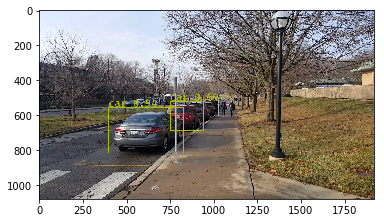

In [10]:
model = CNN_main(im_array_mul)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./checkpoint_dir/yolo2_coco.ckpt")
    bboxes, obj_probs, class_probs=sess.run(box_transfer(model,feat_sizes=(19,19)))
#     scores1, boxes1, classes1 = filter_suppression(obj_probs, bboxes, class_probs, threshold = .6,
#                max_boxes=10, iou_threshold=0.5)
#     scores2, boxes2, classes2 = sess.run([scores1, boxes1, classes1])
#     colors = generate_colors(class_names) 
    np.random.seed(1)
    colors = (np.random.rand(80,3)*[100,100,10]+[155,155,0]).astype(np.int32)
    for i in range(bboxes.shape[0]):
        scores1, boxes1, classes1 = filter_suppression(obj_probs[i], bboxes[i], class_probs[i], threshold = .6,
                                                       max_boxes=10, iou_threshold=0.5)
        scores2, boxes2, classes2 = sess.run([scores1, boxes1, classes1])
        boundingbox(im_mul[i], boxes2, scores2, classes2, class_names, colors, show=False, seq=i)